In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from data_generator_breast import BreastPathQDataset
from models import BreastPathQModel
from uce import uceloss
from calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian

matplotlib.rcParams['font.size'] = 8

In [2]:
base_model = 'efficientnetb4'

In [3]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [4]:
batch_size = 16
resize_to = (384, 384)

data_set = BreastPathQDataset(data_dir='/media/fastdata/laves/breastpathq/', augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./breastpathq_valid_indices.pth')
test_indices = torch.load('./breastpathq_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([600])
torch.Size([1200])


In [5]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=1).to(device)

checkpoint_path = glob(f"/media/fastdata/laves/regression_snapshots/{base_model}_gaussian_breastpathq.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 447 from
/media/fastdata/laves/regression_snapshots/efficientnetb4_gaussian_breastpathq.pth.tar


In [6]:
model.eval()
mus_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

        mus_calib.append(mu.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

mu_calib = torch.cat(mus_calib, dim=0).clamp(0, 1)
var_calib = torch.cat(vars_calib, dim=0)
logvar_calib = torch.cat(logvars_calib, dim=0)
target_calib = torch.cat(targets_calib, dim=0)

100%|██████████| 38/38 [02:42<00:00,  4.26s/it]


In [7]:
err_calib = torch.pow(target_calib-mu_calib, 2).sqrt()

uncertainty = 'total'

uncert_calib_aleatoric = logvar_calib.exp()
uncert_calib_epistemic = var_calib

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [8]:
print((err_calib**2).mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

tensor(0.0061, device='cuda:0')
tensor(0.0015, device='cuda:0')
tensor(0.0251, device='cuda:0')
tensor(0.0188, device='cuda:0')


<IPython.core.display.Javascript object>


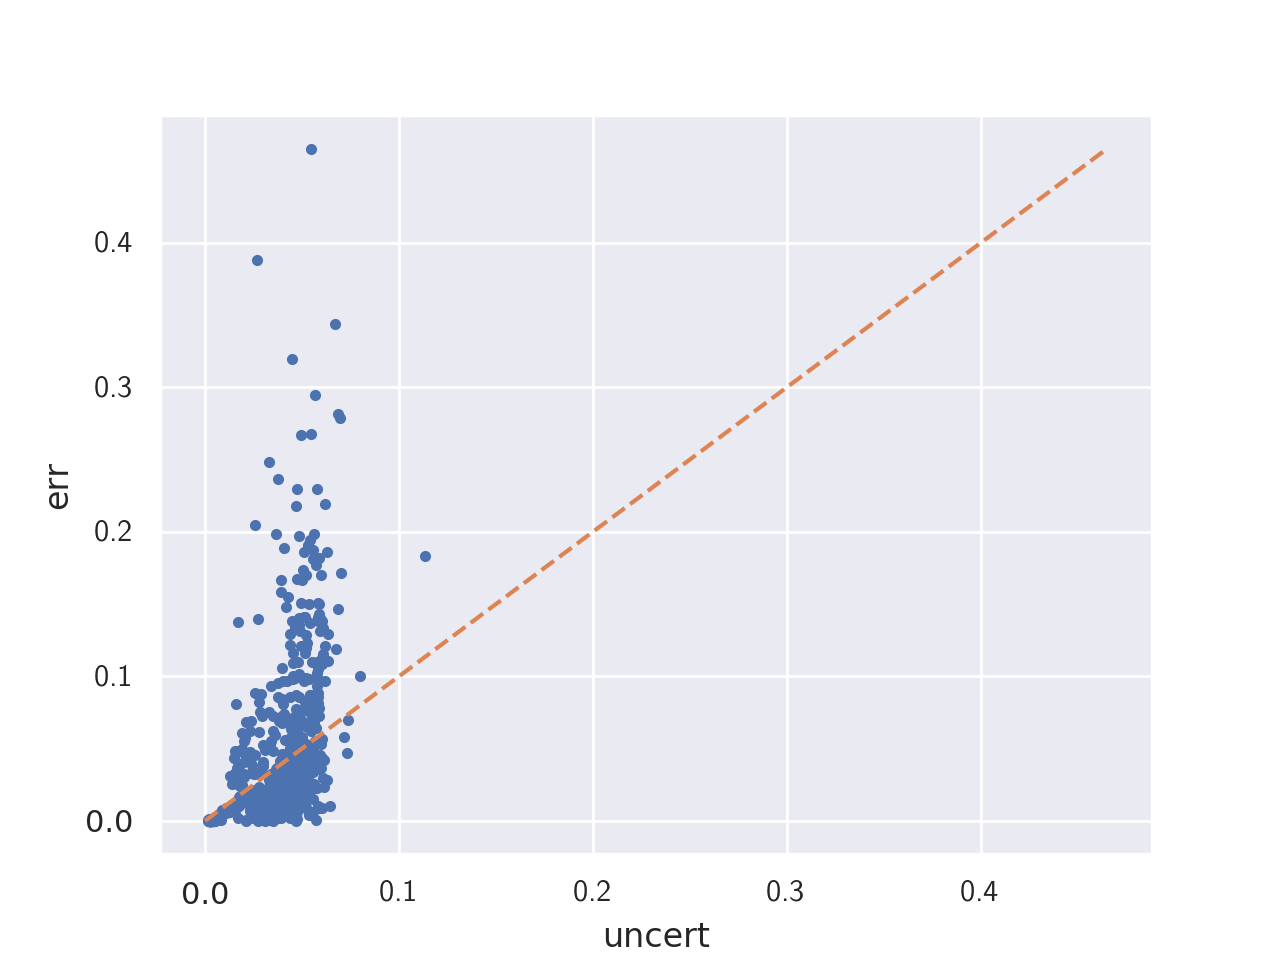

In [9]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

In [10]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(1.7913, device='cuda:0')


In [11]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [12]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.791340708732605


In [13]:
class AuxModel(torch.nn.Module):
    def __init__(self, channels, hidden=16):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels, hidden, bias=True)
        self.fc = torch.nn.Linear(hidden, channels, bias=True)

    def forward(self, x):
        x = 2*(x.log())
        y = self.linear1(x).relu()
        y = self.fc(y)
        
        if self.training:
            return y
        else:
            return (0.5*y).exp()

In [14]:
# find optimal aux
aux = AuxModel(1).to(device)
aux_opt = torch.optim.Adam(aux.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net = optim.lr_scheduler.ReduceLROnPlateau(aux_opt, patience=100, factor=0.1)

aux.train()
for i in range(2000):
    aux_opt.zero_grad()
    loss = nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib)
    loss.backward()
    aux_opt.step()
    lr_scheduler_net.step(loss.item())

print(loss.item())

-6.780628681182861


In [15]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-4.640987396240234
-5.6839599609375
-5.6839599609375
-6.780548095703125


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [16]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.16676923632621765
0.1454431712627411
0.1454431712627411
0.1442023068666458


<IPython.core.display.Javascript object>


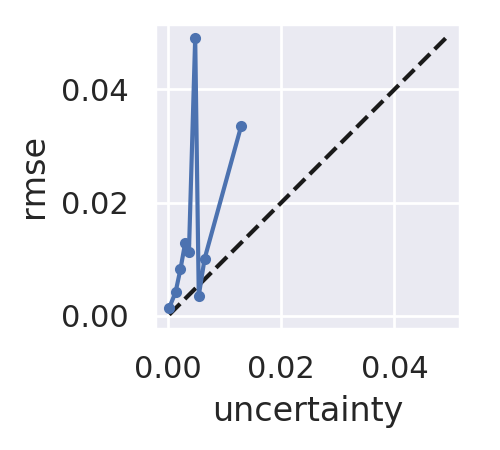

0.4610564559698105


In [17]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


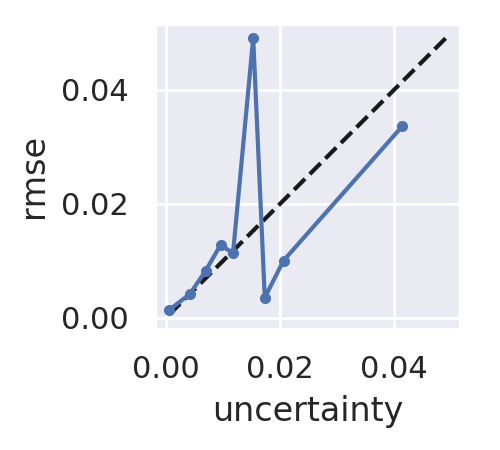

0.15791989862918854


In [18]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


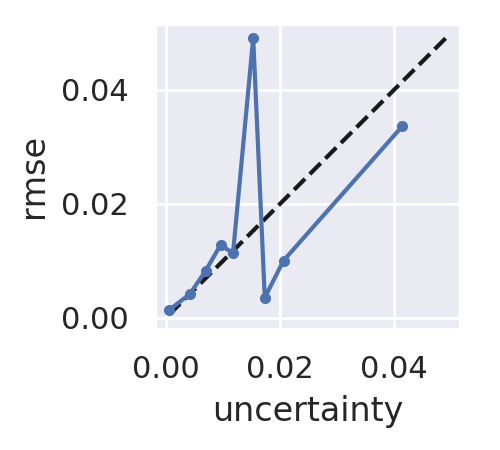

0.15791989862918854


<IPython.core.display.Javascript object>


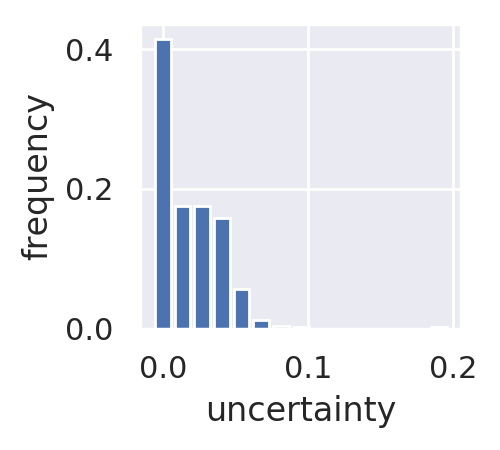

In [19]:
n_bins = 15
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu(), n_bins=n_bins)
fig.show()

<IPython.core.display.Javascript object>


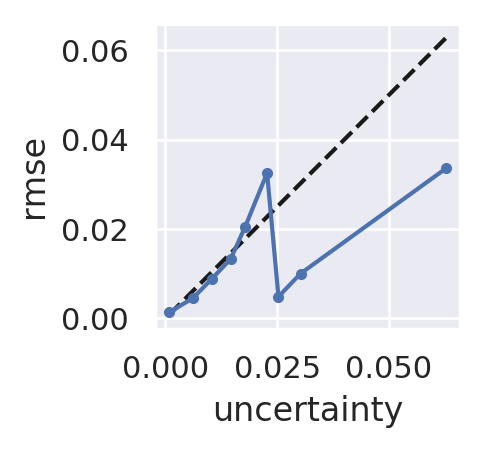

0.12817566748708487


In [20]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

In [21]:
mu_test_list = []
var_test_list = []
logvar_test_list = []
target_test_list = []

for i in range(5):
    mus_test = []
    vars_test = []
    logvars_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            mu, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True)

            mus_test.append(mu.detach())
            vars_test.append(var_bayesian.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())

        mu_test = torch.cat(mus_test, dim=0).clamp(0, 1)
        var_test = torch.cat(vars_test, dim=0)
        logvar_test = torch.cat(logvars_test, dim=0)
        target_test = torch.cat(targets_test, dim=0)

        mu_test_list.append(mu_test)
        var_test_list.append(var_test)
        logvar_test_list.append(logvar_test)
        target_test_list.append(target_test)

100%|██████████| 75/75 [05:27<00:00,  4.37s/it]


In [22]:
err_test = [torch.pow(target_test-mu_test, 2).sqrt() for target_test, mu_test in zip(target_test_list, mu_test_list)]

uncert_aleatoric_test = [logvar_test.exp() for logvar_test in logvar_test_list]
uncert_epistemic_test = [var_test for var_test in var_test_list]

if uncertainty == 'aleatoric':
    uncert_test = uncert_aleatoric_test.sqrt().clamp(0, 1)
elif uncertainty == 'epistemic':
    uncert_test = uncert_epistemic_test.sqrt().clamp(0, 1)
else:
    uncert_test = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]

In [23]:
for i in range(len(err_test)):
    print((err_test[i]**2).mean())
    print((uncert_test[i]**2).mean())
    print()

tensor(0.0059, device='cuda:0')
tensor(0.0015, device='cuda:0')

tensor(0.0059, device='cuda:0')
tensor(0.0015, device='cuda:0')

tensor(0.0059, device='cuda:0')
tensor(0.0015, device='cuda:0')

tensor(0.0059, device='cuda:0')
tensor(0.0015, device='cuda:0')

tensor(0.0059, device='cuda:0')
tensor(0.0015, device='cuda:0')



In [24]:
aux.train()
for i in range(len(mu_test_list)):
    print(nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], (S*uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item())
    print()
aux.eval()

-4.7332763671875
-5.617432594299316
-5.617432594299316
-6.353707790374756

-4.776325225830078
-5.638721466064453
-5.638721466064453
-6.3791890144348145

-4.681114196777344
-5.614035606384277
-5.614035606384277
-6.317950248718262

-4.805367946624756
-5.641864776611328
-5.641864776611328
-6.371708393096924

-4.766834259033203
-5.632400989532471
-5.632400989532471
-6.453657150268555



AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [25]:
for i in range(len(mu_test_list)):
    print(torch.nn.functional.mse_loss(uncert_test[i]**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss((S*uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(scaler(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print()

0.27750295400619507
0.23879235982894897
0.23879235982894897
0.2394043207168579

0.2643147110939026
0.22748693823814392
0.22748693823814392
0.22936898469924927

0.26766538619995117
0.22961628437042236
0.22961628437042236
0.23012034595012665

0.2688765525817871
0.22977685928344727
0.22977685928344727
0.2302720844745636

0.27367377281188965
0.2338126003742218
0.2338126003742218
0.23354080319404602



<IPython.core.display.Javascript object>


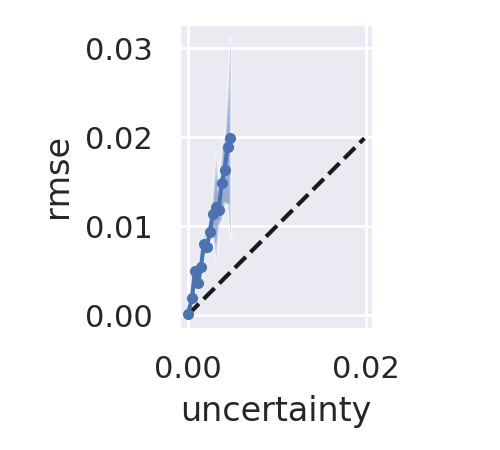

0.436165988445282 0.003632177598774433


In [26]:
if base_model == 'efficientnetb4':
    uce_range = [0, 0.005]
else:
    uce_range = [0, 0.0044]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
for i in range(len(err_test)):
    uce_uncal, _, _, _ = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    _, err_uncal, uncert_uncal, _ = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())

plot_uncert_multi(err_uncal_list, uncert_uncal_list)
print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())

<IPython.core.display.Javascript object>


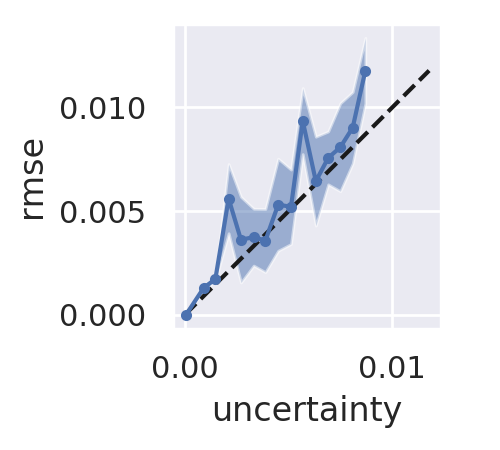

0.11981575191020966 0.010888070799410343


In [27]:
uce_s_list = []
err_s_list = []
uncert_s_list = []
for i in range(len(err_test)):
    uce_s, _, _, _ = uceloss(err_test[i]**2, scaler(uncert_test[i])**2, n_bins=n_bins)
    _, err_s, uncert_s, _ = uceloss(err_test[i]**2, scaler(uncert_test[i])**2, n_bins=n_bins, range=[0, 0.009])
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())

plot_uncert_multi(err_s_list, uncert_s_list)
print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())

#fig, ax = plot_frequency(scaler(uncert_test[0]).cpu(), in_bin.cpu(), n_bins=n_bins)
#fig.show()

<IPython.core.display.Javascript object>


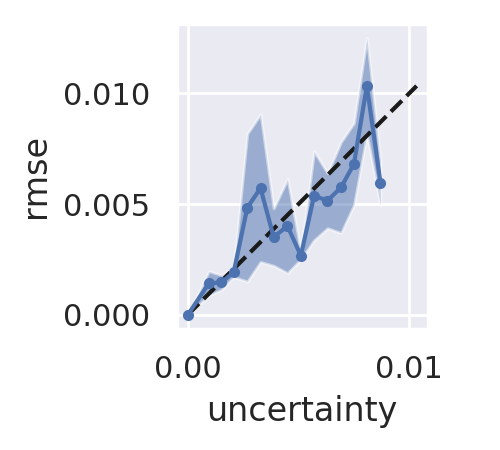

0.12829573452472687 0.018567729741334915


In [28]:
uce_aux_list = []
err_aux_list = []
uncert_aux_list = []
for i in range(len(err_test)):
    uce_aux, _, _, _ = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins)
    _, err_aux, uncert_aux, _ = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins, range=[0, 0.009])
    uce_aux_list.append(uce_aux.cpu())
    err_aux_list.append(err_aux.cpu())
    uncert_aux_list.append(uncert_aux.cpu())

plot_uncert_multi(err_aux_list, uncert_aux_list)
print((torch.stack(uce_aux_list)*100).mean().item(), (torch.stack(uce_aux_list)*100).var().sqrt().item())

In [29]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [30]:
def save_log(base_model):
    with open(f"results_breastpathq_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux", file=f)
        print("NLL", file=f)
        aux.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("s", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_s_list], file=f)
        print("mean", (torch.stack(uce_s_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_s_list)*100).var().sqrt().item(), file=f)
        print("S =", scaler.S.item(), file=f)
        print("", file=f)

In [31]:
if base_model == 'resnet101':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.022], [0, 0.022], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'MSE')
    ax[0].set_xlabel(r'uncertainty')
    ax[0].set_xlim([-0.002, 0.024])
    ax[0].set_ylim([-0.002, 0.024])
    ax[0].set_xticks([0, 0.011, 0.022])
    ax[0].set_yticks([0, 0.011, 0.022])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.012], [0, 0.012], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'MSE')
    ax[1].set_xlabel(r'uncertainty')
    ax[1].set_xlim([-0.001, 0.013])
    ax[1].set_ylim([-0.001, 0.013])
    ax[1].set_xticks([0, 0.006, 0.012])
    ax[1].set_yticks([0, 0.006, 0.012])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.012], [0, 0.012], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'MSE')
    ax[2].set_xlabel(r'uncertainty')
    ax[2].set_xlim([-0.001, 0.013])
    ax[2].set_ylim([-0.001, 0.013])
    ax[2].set_xticks([0, 0.006, 0.012])
    ax[2].set_yticks([0, 0.006, 0.012])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BreastPathQ/ResNet-101', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_breastpathq_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [32]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.015], [0, 0.015], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'MSE')
    ax[0].set_xlabel(r'uncertainty')
    ax[0].set_xlim([-0.001, 0.013])
    ax[0].set_ylim([-0.001, 0.013])
    ax[0].set_xticks([0, 0.006, 0.012])
    ax[0].set_yticks([0, 0.006, 0.012])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.012], [0, 0.012], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'MSE')
    ax[1].set_xlabel(r'uncertainty')
    ax[1].set_xlim([-0.001, 0.013])
    ax[1].set_ylim([-0.001, 0.013])
    ax[1].set_xticks([0, 0.006, 0.012])
    ax[1].set_yticks([0, 0.006, 0.012])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.012], [0, 0.012], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'MSE')
    ax[2].set_xlabel(r'uncertainty')
    ax[2].set_xlim([-0.001, 0.013])
    ax[2].set_ylim([-0.001, 0.013])
    ax[2].set_xticks([0, 0.006, 0.012])
    ax[2].set_yticks([0, 0.006, 0.012])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BreastPathQ/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_breastpathq_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

<IPython.core.display.Javascript object>


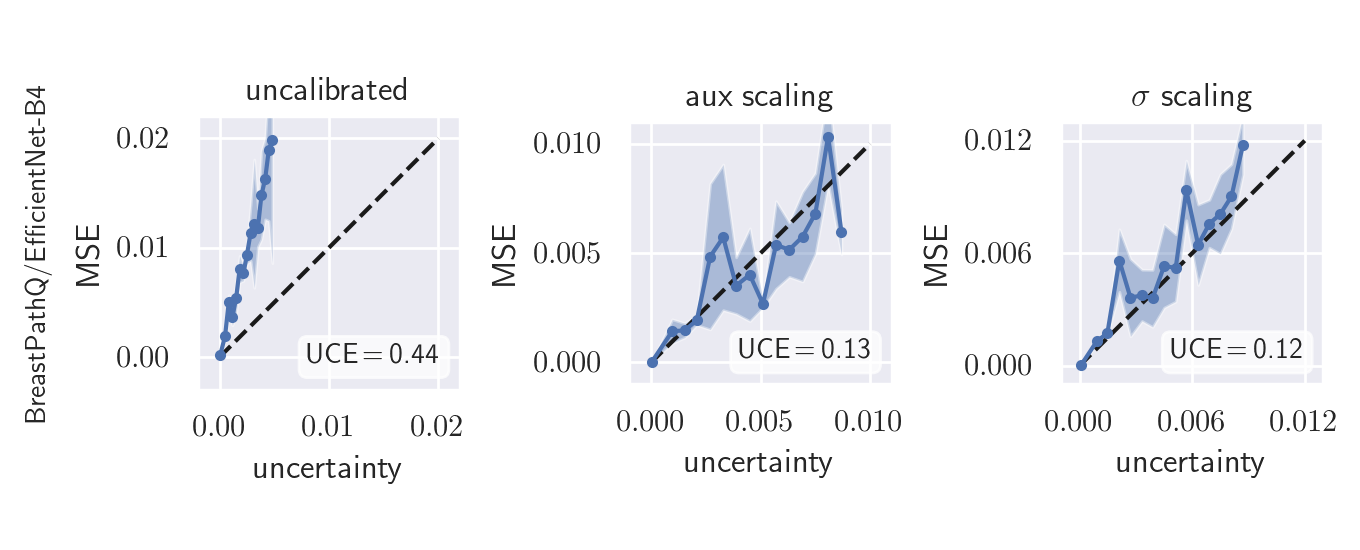

In [33]:
if base_model == 'efficientnetb4':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).std(dim=0).cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.02], [0, 0.02], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'MSE')
    ax[0].set_xlabel(r'uncertainty')
    ax[0].set_xlim([-0.002, 0.022])
    ax[0].set_ylim([-0.003, 0.022])
    ax[0].set_xticks([0, 0.01, 0.02])
    ax[0].set_yticks([0, 0.01, 0.02])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).std(dim=0).cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.010], [0, 0.010], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'MSE')
    ax[1].set_xlabel(r'uncertainty')
    ax[1].set_xlim([-0.001, 0.011])
    ax[1].set_ylim([-0.001, 0.011])
    ax[1].set_xticks([0, 0.005, 0.010])
    ax[1].set_yticks([0, 0.005, 0.010])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).std(dim=0).cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.012], [0, 0.012], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'MSE')
    ax[2].set_xlabel(r'uncertainty')
    ax[2].set_xlim([-0.001, 0.013])
    ax[2].set_ylim([-0.001, 0.013])
    ax[2].set_xticks([0, 0.006, 0.012])
    ax[2].set_yticks([0, 0.006, 0.012])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'BreastPathQ/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_breastpathq_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [34]:
np.save(f"uce_uncal_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uce_uncal_list]))
np.save(f"err_uncal_breastpathq_{base_model}", np.array([i.detach().numpy() for i in err_uncal_list]))
np.save(f"uncert_uncal_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uncert_uncal_list]))

np.save(f"uce_s_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uce_s_list]))
np.save(f"err_s_breastpathq_{base_model}", np.array([i.detach().numpy() for i in err_s_list]))
np.save(f"uncert_s_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uncert_s_list]))

np.save(f"uce_aux_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uce_aux_list]))
np.save(f"err_aux_breastpathq_{base_model}", np.array([i.detach().numpy() for i in err_aux_list]))
np.save(f"uncert_aux_breastpathq_{base_model}", np.array([i.detach().numpy() for i in uncert_aux_list]))